# Case Preparation

In [ ]:
import andes
import ams

In [2]:
%matplotlib inline

In [3]:
andes.config_logger(stream_level=40)
ams.config_logger(stream_level=20)

In [4]:
sp1 = ams.load('./ACTIVSg200/IL200_opf.xlsx',
              setup=True, no_output=True,
              default_config=True)
sp2 = ams.load('./ACTIVSg200/IL200_opf50.xlsx',
              setup=True, no_output=True,
              default_config=True)

Parsing input file "./ACTIVSg200/IL200_opf.xlsx"...
Input file parsed in 0.1583 seconds.
Zero Line parameters detected, adjusted to default values: rate_b, rate_c, amax, amin.
System set up in 0.0033 seconds.
Parsing input file "./ACTIVSg200/IL200_opf50.xlsx"...
Input file parsed in 0.0841 seconds.
Zero Line parameters detected, adjusted to default values: rate_b, rate_c, amax, amin.
System set up in 0.0033 seconds.


In [5]:
for ss in [sp1, sp2]:
    stg_idx = ss.StaticGen.get_all_idxes()
    stg_wt = ss.StaticGen.find_idx(keys='genfuel', values=['wind'], allow_all=True)[0]
    sn_wt = ss.StaticGen.get(src='Sn', attr='v', idx=stg_wt)
    sn_total = ss.StaticGen.get(src='Sn', attr='v', idx=stg_idx)

    print('Wind penetration: {0:.2f}%'.format(
        sn_wt.sum() / sn_total.sum() * 100))

Wind penetration: 19.75%
Wind penetration: 55.96%


In [6]:
for ss in [sp1, sp2]:
    ss.DCOPF.init()
    ss.DCOPF.run(solver='CLARABEL')
    ss.DCOPF.dc2ac()

Building system matrices
Parsing OModel for <DCOPF>
Evaluating OModel for <DCOPF>
Finalizing OModel for <DCOPF>
<DCOPF> initialized in 0.0120 seconds.
<DCOPF> solved as optimal in 0.0460 seconds, converged in 12 iterations with CLARABEL.
Parsing OModel for <ACOPF>
Evaluating OModel for <ACOPF>
Finalizing OModel for <ACOPF>
<ACOPF> initialized in 0.0118 seconds.
<ACOPF> solved in 0.4855 seconds, converged in 20 iterations with PYPOWER-PIPS.
<DCOPF> converted to AC.
Building system matrices
Parsing OModel for <DCOPF>
Evaluating OModel for <DCOPF>
Finalizing OModel for <DCOPF>
<DCOPF> initialized in 0.0128 seconds.
<DCOPF> solved as optimal in 0.0187 seconds, converged in 12 iterations with CLARABEL.
Parsing OModel for <ACOPF>
Evaluating OModel for <ACOPF>
Finalizing OModel for <ACOPF>
<ACOPF> initialized in 0.0071 seconds.
<ACOPF> solved in 0.5661 seconds, converged in 20 iterations with PYPOWER-PIPS.
<DCOPF> converted to AC.


In [7]:
sa1 = sp1.to_andes(addfile='./ACTIVSg200/IL200_dyn_base.xlsx',
                   setup=False, no_output=True,
                   default_config=True)
sa2 = sp2.to_andes(addfile='./ACTIVSg200/IL200_dyn50_ts.xlsx',
                   setup=False, no_output=True,
                   default_config=True)

for ss in [sa1, sa2]:
    # add a Toggle to trip a generator
    ss.add(model='Toggle', param_dict=dict(t=1, model='GENROU', dev='GENROU_10'))
    ss.setup()

Parsing additional file "./ACTIVSg200/IL200_dyn_base.xlsx"...
Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
<PQ> has different number of rows in addfile.
Addfile parsed in 0.1441 seconds.
System converted to ANDES in 0.0645 seconds.
AMS system 0x10e4e8af0 is linked to the ANDES system 0x129e4bd90.
Parsing additional file "./ACTIVSg200/IL200_dyn50_ts.xlsx"...
Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
<PQ> has different number of rows in addfile.
Addfile parsed in 0.1455 seconds.
System converted to ANDES in 0.1086 seconds.
AMS system 0x11e452bc0 is linked to the ANDES system 0x12af47ac0.


In [8]:
sp1.dyn.send(adsys=sa1, routine='DCOPF')
sp2.dyn.send(adsys=sa2, routine='DCOPF')

Send <DCOPF> results to ANDES <0x129e4bd90>...
*Send <vBus> to StaticGen.v0
Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0
Send <DCOPF> results to ANDES <0x12af47ac0>...
*Send <vBus> to StaticGen.v0
Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0


True

In [9]:
for ss in [sa1, sa2]:
    ss.PFlow.run()

    ss.TDS.config.tf = 100
    ss.TDS.config.criteria = 0
    ss.TDS.config.no_tqdm = True
    ss.TDS.run()

<Toggle Toggle_1>: GENROU.GENROU_10 status changed to 0 at t=1.0 sec.
<Toggle Toggle_1>: GENROU.GENROU_10 status changed to 0 at t=1.0 sec.


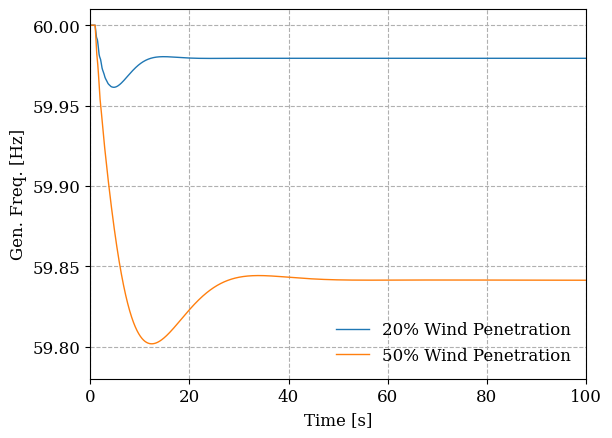

In [12]:
slack_syg = 'GENROU_47'
fig, ax = sa1.TDS.plt.plot(sa1.GENROU.omega,
                           a=(sa1.GENROU.idx2uid(slack_syg)),
                           latex=False, show=False,
                           ytimes=sa1.config.freq,
                           grid=True,
                           ylabel='Gen. Freq. [Hz]',
                           yheader=['20% Wind Penetration'],
                           )
fig, ax = sa2.TDS.plt.plot(sa2.GENROU.omega,
                           a=(sa2.GENROU.idx2uid(slack_syg)),
                           fig=fig, ax=ax,
                           ymin=59.78, ymax=60.01,
                           latex=False, show=False,
                           ytimes=sa2.config.freq,
                           yheader=['50% Wind Penetration'])